<a id="1"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:150%; font-family:Arial; background-color:#C0DDD1; color: #1D3037; overflow:hidden"><b> Sentiment Analysis for Mental Health </b></div>

![mentalhealth](https://img.freepik.com/free-vector/anxiety-concept-illustration_114360-8074.jpg?t=st=1724423293~exp=1724426893~hmac=df2c665ea2a184797d9d3bac091a98ebb6d360a4827e62d62be92a4f04edfd5b&w=1380)

Mental health is a critical aspect of overall well-being, and understanding the nuances of mental health conditions can be a powerful tool in providing timely support and interventions. In this project, we perform sentiment analysis on textual data to predict the mental health status of individuals based on their statements. By analyzing the language used in these statements, we aim to accurately classify them into one of seven mental health categories: Normal, Depression, Suicidal, Anxiety, Stress, Bi-Polar, and Personality Disorder.

By applying advanced natural language processing (NLP) techniques and machine learning models, we seek to classify these statements accurately. The insights from this analysis could help mental health professionals in early identification and intervention. 

This notebook is a collaborative effort between the data scientists: - **Anna Balatska**: [Kaggle Profile](https://www.kaggle.com/annastasy) - **Rabie El Kharoua**: [Kaggle Profile](https://www.kaggle.com/rabieelkharoua). And it is our second project together, continuing the success of our previous collaboration. You can check out our first project [🦠Skin Cancer Detection|Transfer Learning|13-Model](https://www.kaggle.com/code/rabieelkharoua/skin-cancer-detection-transfer-learning-13-model).

In [ ]:
from IPython.display import display, HTML

display(HTML('''
<div style="display: flex; justify-content: space-between; align-items: center; width: 300px; margin: 0 auto;">
    <!-- Left Circle Image -->
    <div style="width: 120px; height: 120px; overflow: hidden; border-radius: 50%; display: inline-block;">
        <img src="https://i.postimg.cc/Sx3LT77N/2023-06-02-11-25-26-286-0500-2.jpg" alt="Left Image" style="width: 100%; height: 100%; object-fit: cover;">
    </div>
    
    <!-- Right Circle Image -->
    <div style="width: 120px; height: 120px; overflow: hidden; border-radius: 50%; display: inline-block;">
        <img src="https://i.postimg.cc/fbJY8vKH/IMG-20240826-WA0007.jpg" alt="Right Image" style="width: 100%; height: 100%; object-fit: cover;">
    </div>
</div>
'''))


<a id="libraries"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:9px; color:white; margin:0; font-size:110%; font-family:Arial; background-color:#419D78; overflow:hidden"><b> 1. Importing Required Libraries </b></div>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

<a id="data"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:9px; color:white; margin:0; font-size:110%; font-family:Arial; background-color:#419D78; overflow:hidden"><b> 2. Reading and Understanding our Data </b></div>

In [ ]:
df = pd.read_csv('Combined Data.csv', index_col=0)

In [ ]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


### Removing missing data

In [ ]:
df.isna().sum()

statement    362
status         0
dtype: int64

In [ ]:
df.dropna(inplace = True)
df.isna().sum()

statement    0
status       0
dtype: int64

### Looking at target variable

In [ ]:
df.status.value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

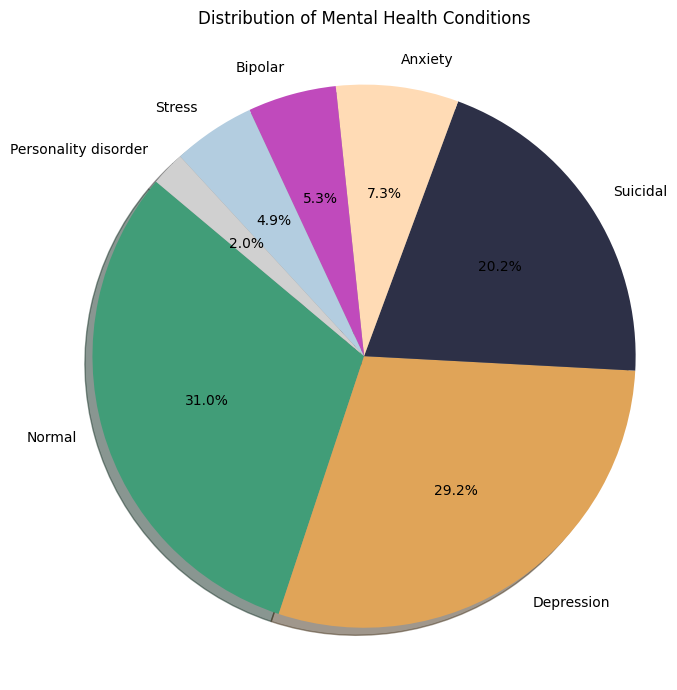

In [ ]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

<div style="padding: 20px; border-color: #419D78; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid #419D78;">
    <ul style="font-size: 18px; font-family: 'Arial'; line-height: 1.5em; ">
        The target variable in our dataset is <strong>unbalanced</strong>. This imbalance could affect our model's performance, so we'll need to address it later to ensure accurate and fair predictions.
    </ul>
</div>

### Looking at raw texts

In [ ]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Hey. I don't understand anxiety as a whole. Don't get me wrong, I'm not denying it's existance. That being said, Jessie J's description of it on the Diary of a CEO made me realise I might have it. I'm perfectly fine performing tasks in X situation but doing the same in Y I shake, have weakness lifting stuff etc based on environment, people etc. is this anxiety?

I've not being diagnosed at all because this is a "recent" development.

Status: Bipolar
Statement: Dealing with self-loathing? I'm just wondering if anyone has any tips for coping with extreme self loathing.

I'm medicated and in therapy, but neither of these things seem to help when the self hatred hits me hard. I guess this would be considered a depressive episode, but i don't really get manic anymore, so who really knows. 

I just hate myself so much that it makes me suicidal. I wish i was someone else entirely or that i just didn't exist. I've hated myself for most of my life. Probably since pube

### Adding new features

In [ ]:
# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.280215
std           846.269078         10.688388
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


<div style="padding: 20px; border-color: #419D78; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid #419D78;">
    <ul style="font-size: 18px; font-family: 'Arial'; line-height: 1.5em; ">
        We have several lengthy messages, most of which express suicidal thoughts or signs of depression:
    </ul>
</div>

In [ ]:
df[df['num_of_characters'] > 10000]

,statement,status,num_of_characters,num_of_sentences
7851,So introduction I guess.. my name is Michael a...,Depression,10679,136
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,1
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,139
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,237
11537,"The title is not meant to discourage others, b...",Depression,12304,155
11581,I no longer know what else to do but write thi...,Depression,13530,140
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,96
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,155
13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759,1260
18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,180


<a id="preprocessing"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:9px; color:white; margin:0; font-size:110%; font-family:Arial; background-color:#419D78; overflow:hidden"><b> 3. Text Preprocessing </b></div>

## 3.1. Lowercasing 

Convert all statements to lowercase to ensure uniformity.

In [ ]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)  

df['statement']=df['original_statement'].str.lower()
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,"i'm restless and restless, it's been a month n..."


## 3.2. Removing URLs, handles, punctuation and special characters

To remove specific patterns such as URLs or other unwanted text (like ```[View Poll](https://www.reddit.com/poll/...)```) from a column in a pandas DataFrame, we can use regular expressions with the re module or pandas built-in string methods.

In [ ]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


## 3.3. Tokenization

Split text into individual words or tokens.

In [ ]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


## 3.4. Stemming

Reduce words to their base or root form. However, in some cases, the stemming process produces words that are not correct spellings of the root word. For example, **happi** and **sunni**. That's because it chooses the most common stem for related words. For example, we can look at the set of words that comprises the different forms of happy:

- happy
- happiness
- happier

We can see that the prefix **happi** is more commonly used. We cannot choose **happ** because it is the stem of unrelated words like **happen**.

In [18]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens,tokens_stemmed
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


## 3.5. Stop Words

While stop words are typically removed to reduce noise, in sentiment analysis for mental health, many stop words are actually crucial for understanding context and sentiment. Words like negations and those related to emotions (e.g., 'how', 'why', 'because') provide important insights. Removing these can decrease the accuracy of the analysis.

##  3.6. Word Clouds

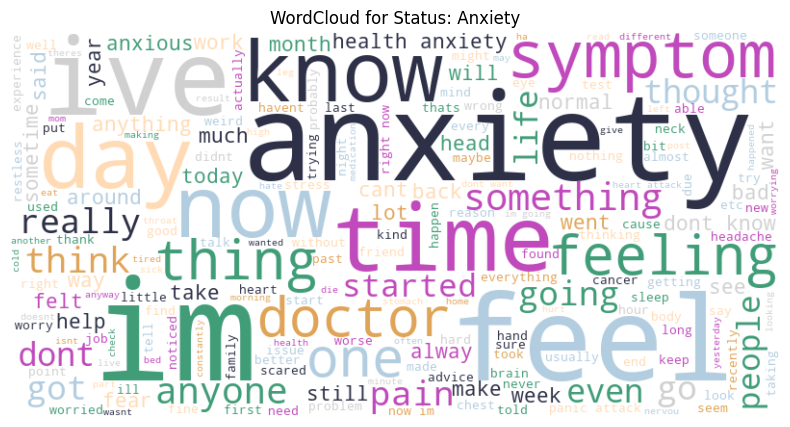

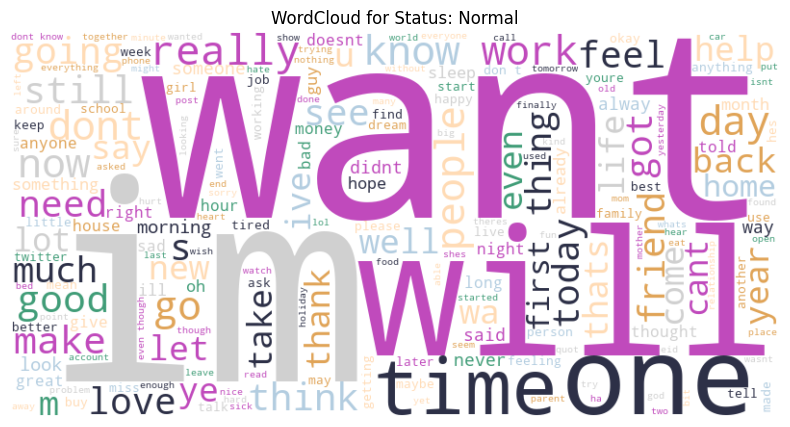

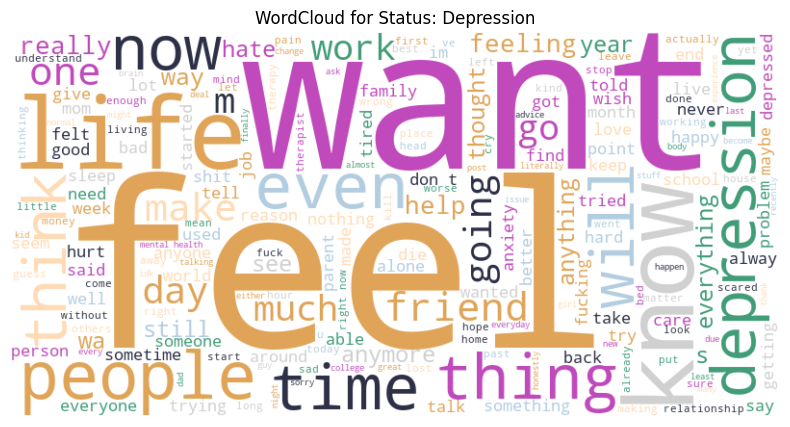

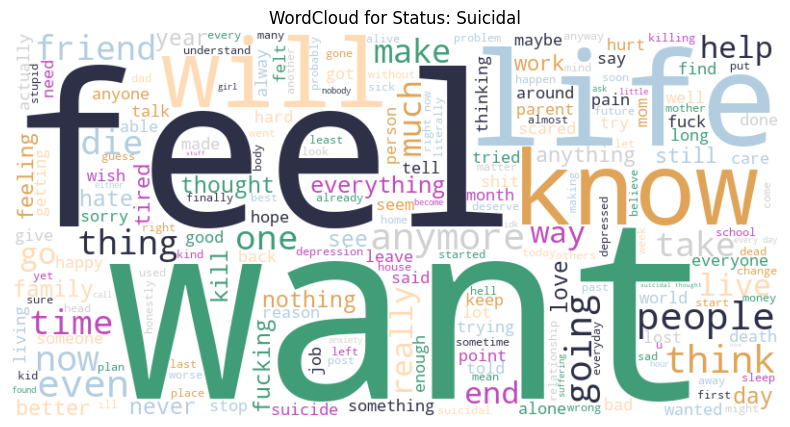

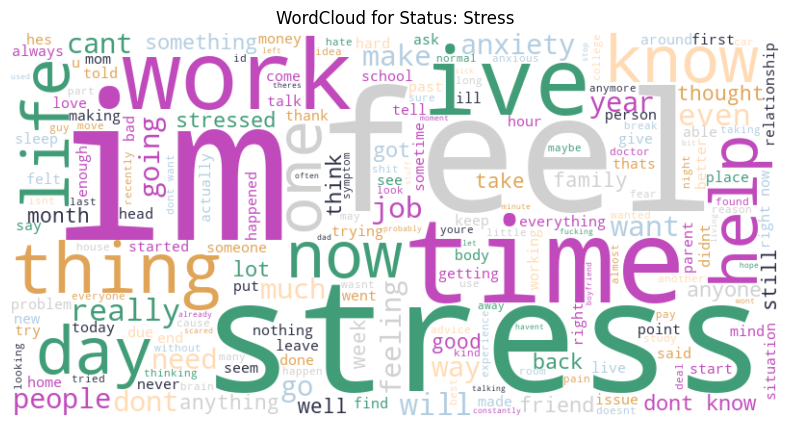

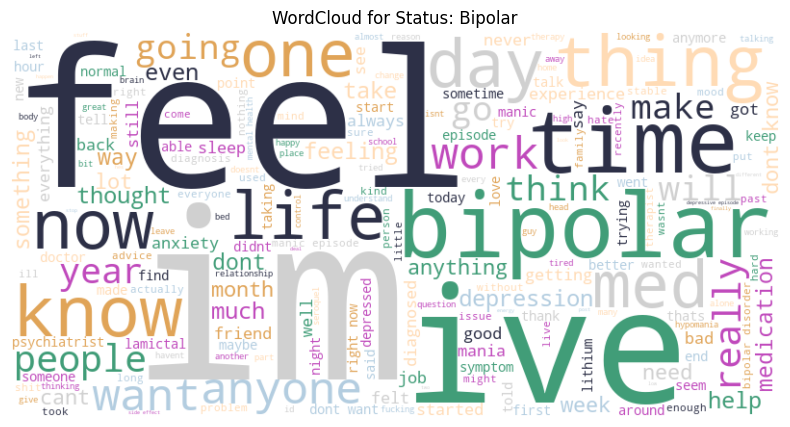

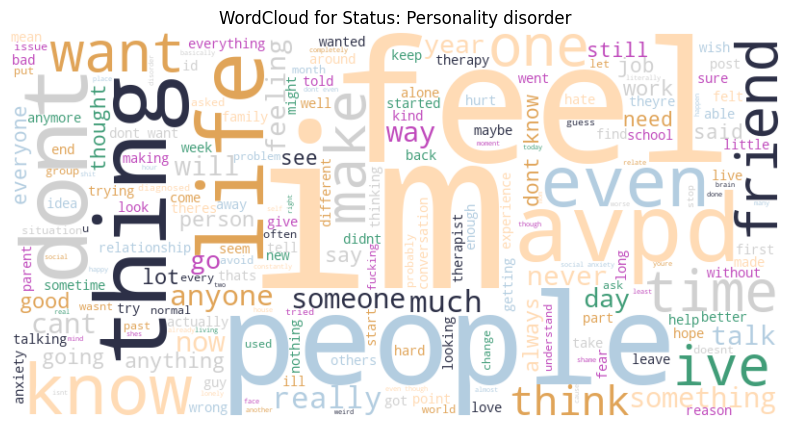

In [ ]:
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()


<div style="padding: 20px; border-color: #419D78; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid #419D78;">
    <ul style="font-size: 18px; font-family: 'Arial'; line-height: 1.5em; ">
        There is a significant overlap in the language used for discussing depression and suicidal thoughts in our data. Many terms and phrases are used interchangeably or similarly for both conditions, which may complicate the distinction between them. 
    </ul>
</div>

<a id="datapreprocessing"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:9px; color:white; margin:0; font-size:110%; font-family:Arial; background-color:#419D78; overflow:hidden"><b> 4. Data Preprocessing </b></div>

## 4.1. Separate features and labels

In [20]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

## 4.2. Label encoding target variable

In [21]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

## 4.3. Split the data into training and testing sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

## 4.4. Convert text to features using TF-IDF vectoriser

Now, we will transform tokens (words) into numerical values that represent the importance of words in a document relative to a collection of documents. This helps highlight unique words in a document while downplaying common ones, making it easier for machine learning models to identify relevant patterns and make better predictions.

In [23]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [24]:
X_train_combined.shape

(42144, 50002)

## 4.5. Resampling

We experimented with various resampling techniques, including SMOTE, Random Over-Sampling and Random Under-Sampling. Among these, Random Over-Sampling provided the best results. 

In [25]:
# Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

In [26]:
X_train_resampled.shape

(91742, 50002)

<a id="model"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:9px; color:white; margin:0; font-size:110%; font-family:Arial; background-color:#419D78; overflow:hidden"><b> 5. Model Traning and Evaluation </b></div>

In [27]:
# Define a dictionary of classifiers with their specific parameters.
# Note: The hyperparameters for these classifiers were chosen after performing GridSearchCV to optimize performance.
classifiers = {
    'Bernoulli Naive Bayes': BernoulliNB(alpha=0.1, binarize=0.0),
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=101), 
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101),
    'XGB': XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=101, tree_method='gpu_hist')
}



For Bernoulli Naive Bayes
Accuracy: 0.6405997912119199
                      precision    recall  f1-score   support

             Anxiety       0.66      0.60      0.63       768
             Bipolar       0.70      0.58      0.64       566
          Depression       0.66      0.48      0.55      3050
              Normal       0.67      0.93      0.78      3237
Personality disorder       0.86      0.34      0.49       202
              Stress       0.41      0.51      0.46       530
            Suicidal       0.59      0.54      0.56      2184

            accuracy                           0.64     10537
           macro avg       0.65      0.57      0.59     10537
        weighted avg       0.64      0.64      0.63     10537



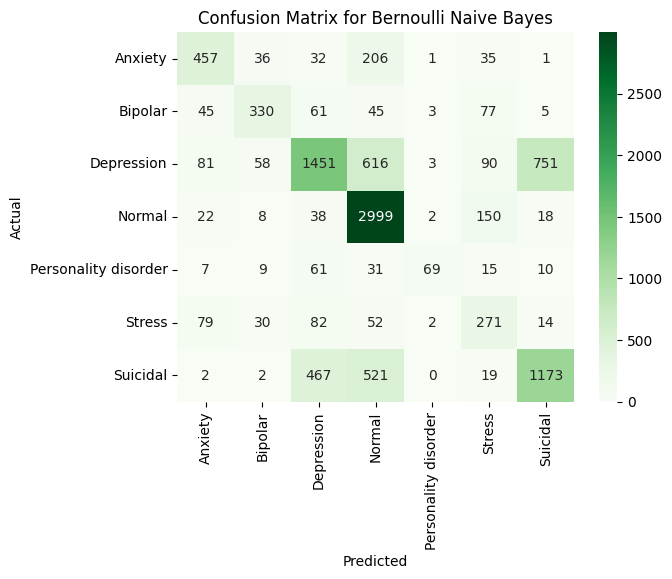



For Decision Tree
Accuracy: 0.6184872354560121
                      precision    recall  f1-score   support

             Anxiety       0.69      0.55      0.61       768
             Bipolar       0.45      0.64      0.52       566
          Depression       0.80      0.34      0.48      3050
              Normal       0.87      0.85      0.86      3237
Personality disorder       0.58      0.43      0.49       202
              Stress       0.24      0.80      0.37       530
            Suicidal       0.52      0.66      0.58      2184

            accuracy                           0.62     10537
           macro avg       0.59      0.61      0.56     10537
        weighted avg       0.70      0.62      0.62     10537



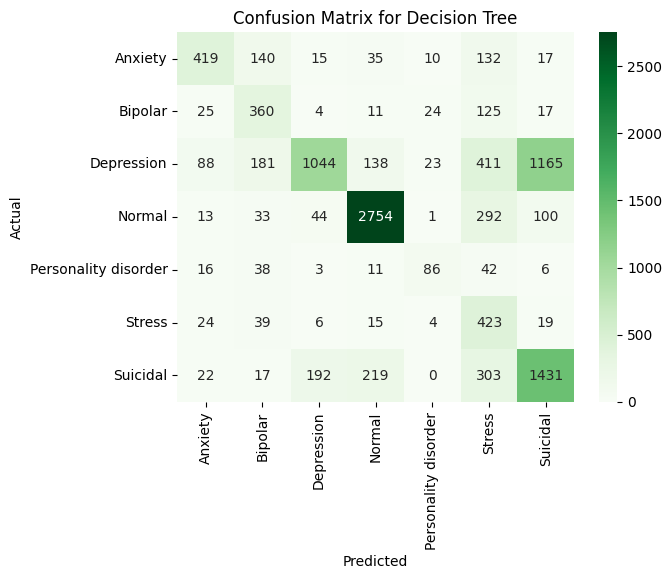



For Logistic Regression
Accuracy: 0.76321533643352
                      precision    recall  f1-score   support

             Anxiety       0.79      0.80      0.80       768
             Bipolar       0.84      0.79      0.81       566
          Depression       0.71      0.67      0.69      3050
              Normal       0.90      0.92      0.91      3237
Personality disorder       0.71      0.65      0.68       202
              Stress       0.60      0.65      0.62       530
            Suicidal       0.65      0.68      0.66      2184

            accuracy                           0.76     10537
           macro avg       0.74      0.74      0.74     10537
        weighted avg       0.76      0.76      0.76     10537



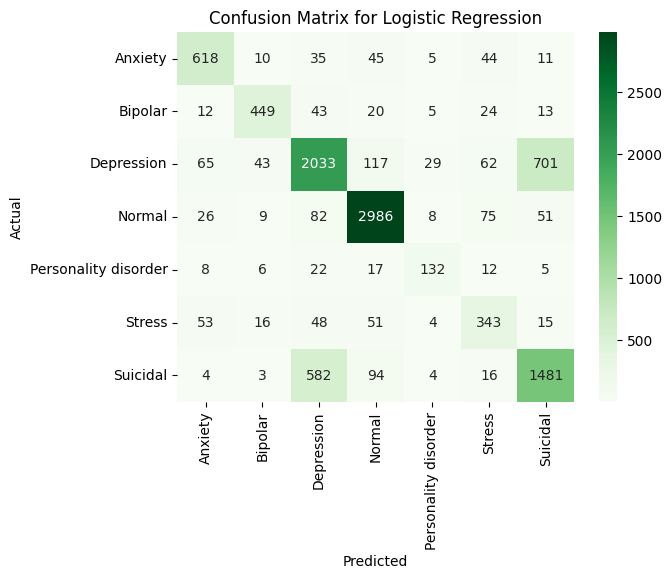

XGBoostError: [10:03:07] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [10:03:07] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\device_helpers.cuh:393: Memory allocation error on worker 0: bad allocation: cudaErrorMemoryAllocation: out of memory
- Free memory: 90963968
- Requested memory: 4684450560



In [28]:
# Initialize a list to store accuracy scores for each classifier
accuracy_scores = []

# Iterate over each classifier and its name in the classifiers dictionary
for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)
    
    print("\n")
    print("For", name)
    print("Accuracy:", accuracy)
    
    # Compute the confusion matrix for the predictions
    # 'lbl_enc.classes_' provides the class labels for the confusion matrix and classification report
    labels = lbl_enc.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=labels))
    
    # Plot the confusion matrix using a heatmap
    # Annotate each cell with the numeric value of the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')  # Label for x-axis
    plt.ylabel('Actual')     # Label for y-axis
    plt.title(f'Confusion Matrix for {name}')  # Title for the heatmap
    plt.show()  # Display the heatmap
    
    # Append the accuracy score to the list
    accuracy_scores.append(accuracy)


In [ ]:
# Create a DataFrame to store classifier names and their corresponding accuracy scores
accuracies_df = pd.DataFrame({'Classifier': classifiers.keys(), 'Accuracy': accuracy_scores}).sort_values('Accuracy', ascending=False)

plt.figure(figsize=(12, 8))
palette = dict(zip(accuracies_df['Classifier'], colors[:4]))

# Create a bar plot to visualize the accuracy of each classifier
sns.barplot(x='Classifier', y='Accuracy', data=accuracies_df, palette=palette)

plt.title("Classifier Accuracy Comparison")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

<div style="padding: 20px; border-color: #419D78; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid #419D78;">
    <ul style="font-size: 18px; font-family: 'Arial'; line-height: 1.5em; ">
        In our project, we evaluated four models designed to handle large datasets with numerous features: <strong>Bernoulli Naive Bayes</strong>, <strong>Decision Tree</strong>, <strong>Logistic Regression</strong>, and <strong>XGBoost (XGB)</strong>. <strong>XGBoost</strong> emerged as the top performer with an <strong>accuracy of 81%</strong>. The classification report showed that the Normal state was the easiest to distinguish with an F1 score of 93, followed by Anxiety and Bipolar with F1 scores of 85. Other states also performed well, with F1 scores above 70. Although the Confusion Matrix and WordCloud analysis revealed some overlap between depression and suicidal messages, XGBoost still outperformed the other models and demonstrated superior overall performance.
    </ul>
</div>